# Apresentação:

A ideia desse *notebook* é pegar todos o conteúdo do curso.

In [3]:
# Bibliotecas:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset,DataLoader

# Steps to maximize performance

Quando enfrentamos um novo desafio de aprendizado profundo, devemos seguir uma série de etapas para garantir que estamos alcançando o melhor resultado possível. Primeiro, precisamos criar um modelo que possa *overfit* no conjunto de treinamento. Ao fazer isso, podemos garantir que o problema seja solucionável. Também estabelecemos uma linha de base de desempenho para mirar com o conjunto de validação. Em seguida, precisamos reduzir o *overfitting* para aumentar o desempenho no conjunto de validação. Por fim, podemos ajustar ligeiramente os diferentes hiperparâmetros para garantir que estejamos alcançando o melhor desempenho possível.

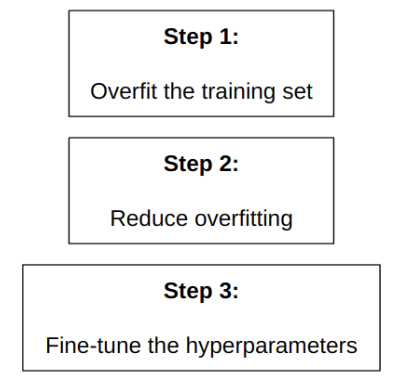

In [23]:
# Gerando dados Artificiais:
x = np.random.rand(200,200)
y = np.random.randint(2, size=x.shape[0])

# Preparando contagem de quantidade de classes:
_, contagem = np.unique(y, return_counts=True)

# Definindo elementos do modelo:
n_features = x.shape[1]
n_classes = sum(contagem.shape)

# Preparando dados:
dataset = TensorDataset(torch.tensor(x).float(), torch.tensor(y).float())
dataloader = DataLoader(dataset,batch_size = 2 , shuffle=True)

# Instanciando Modelo:
model = nn.Sequential(
    nn.Linear(n_features, n_features),   # Primeira Camada Linear, entrada: 5, saída: 5
    nn.Linear(n_features, 20),           # Segunda Camada Linear, entrada: 5, saída: 20
    nn.Linear(20, 10),          # Terceira Camada Linear, entrada: 20, saída: 10
    nn.Linear(10, n_classes),   # Camada de saída, entrada: 10, saída: número de classes
    nn.Softmax(dim=-1)          # Função de ativação Softmax
)

# Definindo função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 1º Passo: overfit do conjunto de treino

Antes de fazer o *overfitting* de todo o conjunto de treinamento, é recomendado fazer o *overfitting* de um único ponto de dados. Isso pode ser feito modificando ligeiramente o loop de treinamento de modo que não iteremos mais pelo `dataloader`. Fazer o *overfitting* de um único ponto de dados deve nos dar uma precisão de $\small 1$ e uma perda próxima de $\small zero$.

In [24]:
features,labels = next(iter(dataloader))

for i in trange(1000):
  # Feedforward
  outputs = model(features)

  # Calculo da perda
  loss= criterion(outputs,labels.long())

  # Backpropagation:
  loss.backward()
  optimizer.step()

# Checando perda:
loss

100%|██████████| 1000/1000 [00:01<00:00, 610.92it/s]


tensor(0.3133, grad_fn=<NllLossBackward0>)

Também deve nos ajudar a encontrar possíveis bugs no código se esses valores não forem alcançados. Em seguida, podemos fazer o *overfitting* de todo o conjunto de treinamento. Nesta fase, não devemos experimentar com a arquitetura do modelo, mas sim usar uma existente, se possível. O modelo deve ser grande o suficiente para que possa *overfit* no conjunto de treinamento. Da mesma forma, os diferentes hiperparâmetros, como a taxa de aprendizado, devem ser mantidos em seus valores padrão.

# 2º Passo: Redução do overfitting

Com o passo anterior, mostramos que o problema é solucionável com aprendizado profundo. Agora precisamos criar um modelo que **generalize bem** para maximizar a precisão de validação.

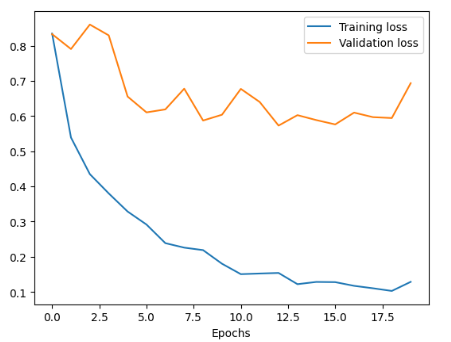

Conhecemos algumas estratégias para reduzir o *overfitting*, como *dropout*, aumento de dados (*data augmentation*), *weight decay* ou redução da capacidade do modelo. Precisamos acompanhar os diferentes parâmetros e a precisão de validação correspondente para cada conjunto de experimentos.

In [26]:
# Utilizando o método de regulazização com o weight decay:
optimizer_regularized = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)

In [27]:
for i in trange(1000):
  # Feedforward
  outputs = model(features)

  # Calculo da perda
  loss= criterion(outputs,labels.long())

  # Backpropagation:
  loss.backward()
  optimizer_regularized.step()

# Checando perda:
loss

100%|██████████| 1000/1000 [00:01<00:00, 567.80it/s]


tensor(0.3133, grad_fn=<NllLossBackward0>)

Precisamos acompanhar os diferentes parâmetros e a precisão de validação correspondente para cada conjunto de experimentos.

Nota:

    Na pratica não mudou nada, mas o objetivo aqui é checar o funcionamento
    não a qualidade do resutaldo. Não estamos operando com dados reais, mas
    sim com uma artificialização que não se aplica no contexto real.

# 3º Passo: fine-tuning hiperparametros

Uma vez satisfeitos com o desempenho, podemos realizar o passo final para ajustar os diferentes hiperparâmetros. Se tivermos capacidade computacional, podemos realizar uma busca em grade (*grid search*) pelos diferentes hiperparâmetros. Uma outra possibilidade é a busca aleatória, (*random search*). É uma opção computacionalmente menos custosa.


## Grid Search

In [36]:
# Aplicando o gridsearch com Adam como optimizer
for factor_grid in trange(2,6):
  lr = 10 ** - factor_grid
  optimizer_regularized = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Adam não possui momentum

  for i in range(1000):
    # Feedforward
    outputs = model(features)

    # Calculo da perda
    loss= criterion(outputs,labels.long())

    # Backpropagation:
    loss.backward()
    optimizer_regularized.step()

  # Checando perda:
  print(f'{lr} -> {loss}')

 25%|██▌       | 1/4 [00:02<00:08,  2.77s/it]

0.01 -> 0.31326165795326233


 50%|█████     | 2/4 [00:05<00:05,  2.50s/it]

0.001 -> 0.31326165795326233


 75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]

0.0001 -> 0.31326165795326233


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

1e-05 -> 0.31326165795326233


Normalmente, isso é feito nos parâmetros do **otimizador**, como a `lr`, taxa de aprendizado ou `momentum`. O *grid search* usará valores dos parâmetros em um intervalo constante.


Nota:

    Esse é o ultima parte do processo inclusive e aqui tempos uma certa
    arte no funcionamento dessa etapa. A otimização de hiperparâmetros não
    salva o modelo, pode dar uma melhora, mas não o suficiente para salvar
    um modelo ruim. E pode ser que nem adiante também, ou piore o modelo.

In [37]:
# Aplicando o gridsearch com SGD como optimizer
for factor_grid in trange(2,6):
  lr = 10 ** - factor_grid
  momentum = .9 - factor_grid * .01
  optimizer_regularized = optim.SGD(model.parameters(), lr=lr, momentum = momentum, weight_decay=1e-4)

  for i in range(1000):
    # Feedforward
    outputs = model(features)

    # Calculo da perda
    loss= criterion(outputs,labels.long())

    # Backpropagation:
    loss.backward()
    optimizer_regularized.step()

  # Checando perda:
  print(f'{lr} -> {loss}')

 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

0.01 -> 0.31326165795326233


 50%|█████     | 2/4 [00:02<00:02,  1.37s/it]

0.001 -> 0.31326165795326233


 75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

0.0001 -> 0.31326165795326233


100%|██████████| 4/4 [00:05<00:00,  1.25s/it]

1e-05 -> 0.31326165795326233


## Random Search

In [43]:
# Definido a lista de valores:
factor_random_search = [np.random.uniform(2,6) for _ in range(4)];factor_random_search

[3.8331871592951186, 3.2138616471386543, 5.09264545318211, 2.941965572890968]

In [46]:
# Aplicando o gridsearch com Adam como optimizer
for factor_random in tqdm(factor_random_search):
  lr = 10 ** - factor_random
  optimizer_regularized = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Adam não possui momentum

  for i in range(1000):
    # Feedforward
    outputs = model(features)

    # Calculo da perda
    loss= criterion(outputs,labels.long())

    # Backpropagation:
    loss.backward()
    optimizer_regularized.step()

  # Checando perda:
  print(f'{lr} -> {loss}')

 25%|██▌       | 1/4 [00:01<00:05,  1.72s/it]

0.00014682933799498797 -> 0.31326165795326233


 50%|█████     | 2/4 [00:03<00:03,  1.68s/it]

0.0006111366832441852 -> 0.31326165795326233


 75%|███████▌  | 3/4 [00:04<00:01,  1.65s/it]

8.078943051860264e-06 -> 0.31326165795326233


100%|██████████| 4/4 [00:06<00:00,  1.74s/it]

0.0011429689358870175 -> 0.31326165795326233


In [47]:
# Aplicando o gridsearch com SGD como optimizer
for factor_random in tqdm(factor_random_search):
  lr = 10 ** - factor_random
  momentum = np.random.uniform(.85,.99)
  optimizer_regularized = optim.SGD(model.parameters(), lr=lr, momentum = momentum, weight_decay=1e-4)

  for i in range(1000):
    # Feedforward
    outputs = model(features)

    # Calculo da perda
    loss= criterion(outputs,labels.long())

    # Backpropagation:
    loss.backward()
    optimizer_regularized.step()

  # Checando perda:
  print(f'{lr} -> {loss}')

 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

0.00014682933799498797 -> 0.31326165795326233


 50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

0.0006111366832441852 -> 0.31326165795326233


 75%|███████▌  | 3/4 [00:03<00:01,  1.08s/it]

8.078943051860264e-06 -> 0.31326165795326233


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

0.0011429689358870175 -> 0.31326165795326233
